# Data split

In [31]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [32]:
# convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [33]:
data_dir = '/exchange/dspro01/group3/data/train' 
dataset = datasets.ImageFolder(root=data_dir, transform=transform) # assigns labels automatically according to folder's name


In [50]:
num_classes = 12            # number of categories
num_epochs =  25          # set the number of epochs for training # TODO AUGMENT TO 25
learning_rate = 0.001 

In [35]:
# For reproducibility
seed = 42
torch.manual_seed(seed)

In [36]:
total_size = len(dataset)
train_size = int(0.8 * total_size)   
val_size = int(0.2 * total_size)     


In [37]:
# Split
generator = torch.Generator().manual_seed(seed) # For reproducibility
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator) 

In [38]:
len(train_dataset) == (2400 * 12 * 0.8)

True

In [39]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)


# Model

In [40]:
from torchvision import models
import torch.nn as nn

In [41]:
# Load model
model = models.resnet50(pretrained=True)

num_features = model.fc.in_features # Retrieves the number of input features from the current final layer (fc) of the model
model.fc = nn.Linear(num_features, num_classes) # Replaces the existing final layer with a new nn.Linear layer. Full connected - could add more layers

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # Loss function suiting classification problems

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  
# Initial learning rate of 0.001
# weight_decay corresponds to the L2 regularization. Prevents overfitting by penalizing large weight values.

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 
# optim = type of learning rate being used
# optimizer = optimizer whose learning rates are being adjusted
# Step size = number of epochs between parameters adjustments
# gamma = The factor by which the learning rate is reduced at each step.

In [44]:
# Move the model to a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [45]:
# Create dataloaders dictionary
dataloaders = {'train': train_loader, 'val': val_loader}

In [46]:
# Create dataset_sizes dictionary for calculating losses and accuracies
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [47]:
# TODO running variable. If x last epochs were not better, then stop.

In [51]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize variables to track the best model
best_val_loss = 0.0
best_model_path = 'best_model.pth'



for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    for phase in ['train', 'val']: # TODO SPLIT IN TWO LOOPS
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluation mode

        running_loss = 0.0 # loss between each epoch
        running_corrects = 0 # number of correct per epoch

        # Iterate over batches
        for inputs, labels in dataloaders[phase]: # TODO! is applying the transformation at every epoch. 
            #TODO Take out of the loop (nice to have)
            # Move data to the device GPU
            inputs = inputs.to(device) 
            labels = labels.to(device)

            # Resets the gradients of all parameters to zero before the backward pass.
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'): # if train phase, set gradient
                outputs = model(inputs) # Passes the input in the Resnet model
                # outputs contains the raw predictions of the model for each input
                
                _, preds = torch.max(outputs, 1) 
                # Returns the maximum from the outputs, with dimension 1 and a slot for each class
                # Returns 2 tensors: maximum value and its index
                # _ discards the maximum value 
                # Only the index is kept in preds
                
                loss = criterion(outputs, labels) 
                # Computes loss function between outputs and labels
                # Refers to the CrossEntropy loss function defined above

                #  Backpropagation and update the model parameters during training.
                if phase == 'train':
                    loss.backward()
                    optimizer.step() # in which direction to go - -gradient
            
            # Statistics
            running_loss += loss.item() * inputs.size(0) # for input size (last batch might be smaller, remaining data)
            running_corrects += torch.sum(preds == labels.data)  # if the label of the data matches the predictions true
            # Sums all the correct answers
            # In the end, for the epoch because +=

        epoch_loss = running_loss / dataset_sizes[phase] # ok even for last batch if smaller? 
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the metrics
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())


        # Save the best model based on validation accuracy
        if phase == 'val' and epoch_acc > best_val_accuracy:
            best_val_accuracy = epoch_acc
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'accuracy': best_val_accuracy,
            }, best_model_path)
            print(f'Saved best model at epoch {epoch + 1} with validation accuracy: {best_val_accuracy:.4f}')
    
    scheduler.step() 
        
print('Training complete')

# TODO save best model (OR its variables) in the loop based on best accuracy or loss of the validation set


Epoch 1/25
----------
train Loss: 0.5851 Acc: 0.7947
val Loss: 0.6989 Acc: 0.7590
Epoch 2/25
----------
train Loss: 0.5088 Acc: 0.8201
val Loss: 0.7097 Acc: 0.7519
Epoch 3/25
----------
train Loss: 0.2704 Acc: 0.9098
val Loss: 0.4266 Acc: 0.8561
Saved best model at epoch 3 with validation accuracy: 0.8561
Epoch 4/25
----------
train Loss: 0.1760 Acc: 0.9422
val Loss: 0.4446 Acc: 0.8623
Saved best model at epoch 4 with validation accuracy: 0.8623
Epoch 5/25
----------
train Loss: 0.1197 Acc: 0.9612
val Loss: 0.4739 Acc: 0.8642
Saved best model at epoch 5 with validation accuracy: 0.8642
Epoch 6/25
----------
train Loss: 0.0756 Acc: 0.9776
val Loss: 0.5494 Acc: 0.8594
Epoch 7/25
----------
train Loss: 0.0527 Acc: 0.9835
val Loss: 0.5716 Acc: 0.8623
Epoch 8/25
----------
train Loss: 0.0277 Acc: 0.9927
val Loss: 0.5788 Acc: 0.8694
Saved best model at epoch 8 with validation accuracy: 0.8694
Epoch 9/25
----------
train Loss: 0.0212 Acc: 0.9944
val Loss: 0.5972 Acc: 0.8686
Epoch 10/25
------

# Visualization

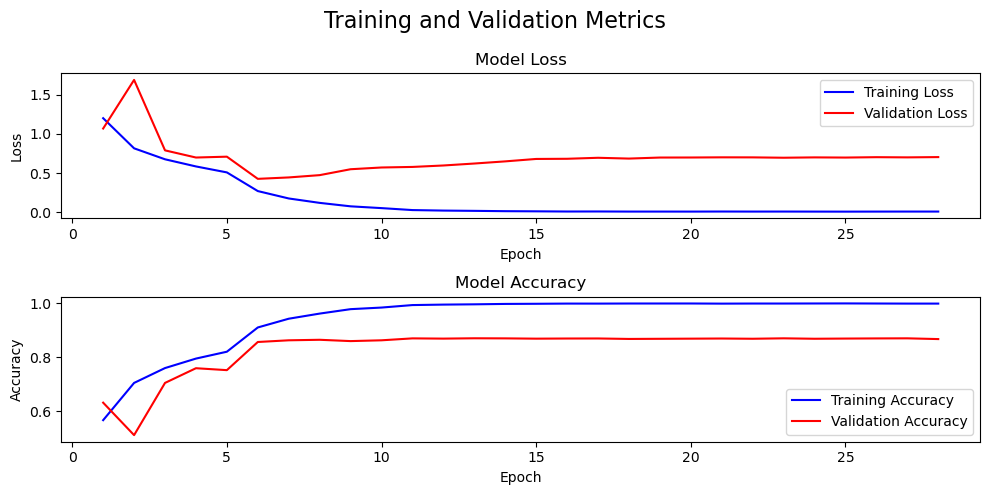

Best validation accuracy: 0.8698 (Epoch 13)
Final accuracy gap (train - val): 0.1313


In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your training output
epochs = range(1, (num_epochs+1)+3)
           
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Plot training & validation loss values
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training & validation accuracy values
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Calculate and print best validation accuracy
best_val_accuracy = max(val_accuracies)
best_epoch = val_accuracies.index(best_val_accuracy) + 1
print(f"Best validation accuracy: {best_val_accuracy:.4f} (Epoch {best_epoch})")

# Calculate and print final training-validation gap
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
acc_gap = final_train_acc - final_val_acc
print(f"Final accuracy gap (train - val): {acc_gap:.4f}")


# Use trained model

In [ ]:
# Assuming you have a model class defined
model = YourModelClass()  # Replace with your model class
model.load_state_dict(torch.load('best_model.pth'))  # Load the saved weights
model.eval()  # Set the model to evaluation mode
